In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [3]:
import sys, os, tqdm
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

True

## Process images for a single patient

- load SITK images from NIFTI files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [7]:
%autoreload
patient = mre_pinn.data.Patient(
    nifti_dir='/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI',
    patient_id='0006',
    sequences=[
        't1_pre_in', 't1_pre_out', 't1_pre_water', 't1_pre_fat', 't2', 'mre_raw', 'wave', 'mre'
    ],
    xarray_dir='../data/NAFLD_test/'
)
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii


size    spacing      origin       limit      center  \
sequence     dimension                                                        
t1_pre_in    0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_out   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_water 0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_fat   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t2           0           256   1.406300 -200.263000  158.343486  -20.959757   
             1           256   1.406300 -208.240997  150.365490  -28.937754   
             2            23  10.000000 -154.516006   65.483994  -44.516006   
mre_raw      0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4   1.000000    0.000000    3.000000    1.500000   
wave         0           512   1.000000    0.000000  511.000000  255.500000   
             1           512   1.000000    0.000000  511.000000  255.500000   
             2             4   1.000000    0.000000    3.000000    1.500000   
mre          0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4  11.000000   -1.056400   31.943600   15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2            4.000000  
wave         0          512.000000  
             1          512.000000  
             2            4.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

In [9]:
%autoreload
patient.preprocess_images()

Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_in to mre_raw
ParameterObject (0x55e7fd274cb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 243971
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2

In [10]:
patient.metadata

size    spacing      origin       limit     center  \
sequence     dimension                                                       
t1_pre_in    0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t1_pre_out   0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t1_pre_water 0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t1_pre_fat   0           512   0.703100 -207.242820  152.041293 -27.600763   
             1           512   0.703100 -196.197807  163.086306 -16.555750   
             2            88   2.300003  -84.606533  115.493733  15.443600   
t2           0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2            23  10.000000  -94.556400  125.443600  15.443600   
mre_raw      0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
wave         0           512   0.703150 -207.255582  152.054055 -27.600763   
             1           512   0.703150 -196.210569  163.099068 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   
mre          0           256   1.406300 -206.904007  151.702480 -27.600763   
             1           256   1.406300 -195.858994  162.747493 -16.555750   
             2             4  11.000000   -1.056400   31.943600  15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2           44.000000  
wave         0          360.012787  
             1          360.012787  
             2           44.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

Converting t1_pre_in to xarray
Converting t1_pre_out to xarray
Converting t1_pre_water to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray


<IPython.core.display.Javascript object>


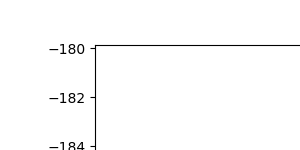

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [11]:
%autoreload
patient.view(compare=True)

In [ ]:
%autoreload
patient.save_xarrays()

In [ ]:
patient.load_xarrays()

## Process images for a patient cohort

In [ ]:
%ls /ocean/projects/asc170022p/shared/Data/MRE/*/NIFTI/ -d

In [ ]:
%cat /ocean/projects/asc170022p/shared/Data/MRE/gold.txt

In [4]:
with open('/ocean/projects/asc170022p/shared/Data/MRE/gold.txt') as f:
    patient_ids = [line.split('.')[0].split('_')[1] for line in f]

len(patient_ids)

181

In [5]:
%autoreload
cohort = mre_pinn.data.PatientCohort(
    nifti_dirs='/ocean/projects/asc170022p/shared/Data/MRE/*/NIFTI',
    patient_ids='{' + ','.join(patient_ids) + '}',
    xarray_dir='../data/NAFLD/'
)
len(cohort)

/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0830 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0838 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0846 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0860 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0872 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1474 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1483 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1495 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1504 is missing sequences {'wave'}
/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1526 

155

In [5]:
%%time
cohort.load_images()

  0%|          | 0/155 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre.nii
  1%|          | 1/155 [00:01<03:28,  1.35s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0900/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0989/mre.nii
  7%|▋         | 11/155 [00:10<02:21,  1.02it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0995/t2.nii
Loading /ocean/projects

 14%|█▎        | 21/155 [00:20<02:10,  1.03it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1106/mre.nii
 14%|█▍        | 22/155 [00:21<02:14,  1.01s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1108/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1207/mre.nii
 21%|██        | 32/155 [00:30<01:52,  1.10it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t2.nii
Loading /ocean/projects

 27%|██▋       | 42/155 [00:39<01:45,  1.07it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1341/mre.nii
 28%|██▊       | 43/155 [00:40<01:40,  1.11it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1343/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1433/mre.nii
 34%|███▍      | 53/155 [00:49<01:33,  1.09it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1435/t2.nii
Loading /ocean/projects

 41%|████      | 63/155 [00:58<01:25,  1.08it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0047/mre.nii
 41%|████▏     | 64/155 [00:59<01:23,  1.09it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre.nii
 48%|████▊     | 74/155 [01:08<01:07,  1.21it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0395/mre_raw.nii
Loading /ocean/projects/asc170022p/s

 54%|█████▍    | 84/155 [01:17<01:06,  1.06it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0235/mre.nii
 55%|█████▍    | 85/155 [01:18<01:03,  1.10it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0457/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFT

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0564/mre.nii
 61%|██████▏   | 95/155 [01:27<00:49,  1.21it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0604/mre_raw.nii
Loading /ocean/projects/asc170022p/s

 68%|██████▊   | 105/155 [01:37<00:50,  1.02s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre.nii
 68%|██████▊   | 106/155 [01:37<00:47,  1.04it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0704/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1679/mre.nii
 75%|███████▍  | 116/155 [01:46<00:32,  1.18it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1694/t2.nii
Loading /ocean/projects/asc17002

 81%|████████▏ | 126/155 [01:55<00:26,  1.11it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1748/mre.nii
 82%|████████▏ | 127/155 [01:56<00:24,  1.13it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1785/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/mre.nii
 88%|████████▊ | 137/155 [02:06<00:18,  1.03s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t2.nii
Loading /ocean/projects/asc17002

 95%|█████████▍| 147/155 [02:16<00:08,  1.06s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1940/mre.nii
 95%|█████████▌| 148/155 [02:18<00:09,  1.34s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1948/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NI

In [6]:
%%time
m = cohort.metadata
m

CPU times: user 2.5 s, sys: 27.2 ms, total: 2.52 s
Wall time: 5.06 s


size    spacing      origin       limit  \
patient_id sequence     dimension                                            
0898       t1_pre_in    0           512   0.820300 -193.358994  225.814298   
                        1           512   0.820300 -265.899994  153.273297   
                        2           120   2.300003  -64.173203  209.527161   
           t1_pre_water 0           512   0.820300 -193.358994  225.814298   
                        1           512   0.820300 -265.899994  153.273297   
...                                 ...        ...         ...         ...   
2046       wave         1           512   1.000000    0.000000  511.000000   
                        2             4   1.000000    0.000000    3.000000   
           mre          0           256   1.484400 -173.035995  205.486013   
                        1           256   1.484400 -209.257996  169.264013   
                        2             4  11.000000  -92.152802  -59.152802   

                                       center      extent  
patient_id sequence     dimension                          
0898       t1_pre_in    0           16.227652  419.993591  
                        1          -56.313348  419.993591  
                        2           72.676979  276.000366  
           t1_pre_water 0           16.227652  419.993591  
                        1          -56.313348  419.993591  
...                                       ...         ...  
2046       wave         1          255.500000  512.000000  
                        2            1.500000    4.000000  
           mre          0           16.225009  380.006409  
                        1          -19.996991  380.006409  
                        2          -75.652802   44.000000  

[3720 rows x 6 columns]

In [ ]:
(m.reset_index().groupby(['patient_id', 'sequence']).dimension.count() == 3) \
    .reset_index().groupby(['patient_id']).dimension.all().all()

In [9]:
%%time
cohort.create_xarrays()

  0%|          | 0/155 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0898/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x556f57dd43f0)
  RTTI typeinfo:

Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x55715fbe07c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 23900331
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49001 -40.622 97.0866)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.124 -235.236 -2.96341)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7617 0.7617 2.3)
  (Transfo

Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x5571584b8ca0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24109613
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -14.1432 -20.0002 129.457)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.765 -219.622 1.80725)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (Transfor

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x55715af86910)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24319057
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -14.7098 -19.9938 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -194 -199.284 -41.3425)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4062 1.4062 6.32499)
  (Transform "EulerTransform")
  (Transfo

Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x55715fbcff60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24528648
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -37.9233 -22.5813 32.6316)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -227.555 -212.213 -85.8186)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (Transfor

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x556f5728f690)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 24738219
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -41.8383 28.0817 110.295)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.171 -141.251 -4.7052)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 24)
  (Spacing 1.3281 1.3281 10)
  (Transform "EulerTransform")
  (TransformParameters 

  (UseDirectionCosines "true")
Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/0954/t1_pre_in.nc
Writing ../data/NAFLD/0954/t1_pre_water.nc
Writing ../data/NAFLD/0954/t1_pre_out.nc
Writing ../data

Writing ../data/NAFLD/0964/t1_pre_out.nc
Writing ../data/NAFLD/0964/t1_pre_fat.nc
Writing ../data/NAFLD/0964/t2.nc
Writing ../data/NAFLD/0964/mre_raw.nc
Writing ../data/NAFLD/0964/wave.nc
Writing ../data/NAFLD/0964/mre.nc
Writing ../data/NAFLD/0964/mask.nc
  5%|▌         | 8/155 [08:27<2:31:54, 62.00s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0965/wave.nii
Loading /ocean/projects/asc170022p/sha

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0979/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0979/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0979/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/0979/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x556f392dae60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25300070
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.26324 -38.9073 51.5384)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombin

Registering t1_pre_water to mre_raw
ParameterObject (0x556f5fdbd280)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25509588
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.60875 -21.7222 1.6932)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.033 -201.364 -135.156)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 120)
  (Spacing 0.7031 0.7031 2.29999)
  (Transform "EulerTransform")
  (TransformParameters -0.03558

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x557146b9f6b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25719089
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.4128 -19.9938 10.2872)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -189.703 -199.284 -87.7498)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4062 1.4062 6.32497)
  (Transform "EulerTransform")
  (Tra

Registering t1_pre_fat to mre_raw
ParameterObject (0x557150157600)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 25928398
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.83825 -20.0048 155.741)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -231.693 -259.536 37.291)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.9375 0.9375 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0373338 -0.0

  (TransformParameters -0.0306 0.00701628 0.00263723 -1.58365 -2.65318 -1.64888)
  (UseDirectionCosines "true")
Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x557146b9a150)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26137684
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -0.962995 -28.591 250.919)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -190.224 -217.852 135.919)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1039/t1_pre_in.nc
Writing ../data/NAFLD/1039/t1_pre_water.nc
Writing ../data/NAFLD/1039/t1_pre_out.nc
Writing ../data/NAFLD/1039/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/1045/t1_pre_fat.nc
Writing ../data/NAFLD/1045/t2.nc
Writing ../data/NAFLD/1045/mre_raw.nc
Writing ../data/NAFLD/1045/wave.nc
Writing ../data/NAFLD/1045/mre.nc
Writing ../data/NAFLD/1045/mask.nc
 10%|█         | 16/155 [16:58<2:23:01, 61.74s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1075/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/10

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1076/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x55715014e2d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26699741
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -1.82199 -34.607 105.681)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTr

Registering t1_pre_water to mre_raw
ParameterObject (0x55715017e060)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 26909153
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 14.223 -45.776 56.6948)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.354 -265.353 -61.7554)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0568296 -0

  (UseDirectionCosines "true")
Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x5571501831c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27118766
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 15.5188 -56.0952 83.7631)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -193.658 -265.272 -51.8619)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 8.75)
  (Transfo

  (UseDirectionCosines "true")
Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x55715018a280)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27328033
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -29.32 -27.513 97.0866)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -248.897 -247.09 -30.5636)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "E

Registering t2 to mre_raw
ParameterObject (0x5570f5492050)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 27537520
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -38.7835 -38.9105 152.733)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -247.96 -248.087 37.7331)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 24)
  (Spacing 1.6406 1.6406 9.99999)
  (Transform "EulerTransform")
  (TransformParameters 0.0230521 0.0104102

  (UseDirectionCosines "true")
Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1108/t1_pre_in.nc
Writing ../data/NAFLD/1108/t1_pre_water.nc
Writing ../data/NAFLD/1108/t1_pre_out.nc
Writing ../data

Writing ../data/NAFLD/1110/t1_pre_out.nc
Writing ../data/NAFLD/1110/t1_pre_fat.nc
Writing ../data/NAFLD/1110/t2.nc
Writing ../data/NAFLD/1110/mre_raw.nc
Writing ../data/NAFLD/1110/wave.nc
Writing ../data/NAFLD/1110/mre.nc
Writing ../data/NAFLD/1110/mask.nc
 15%|█▌        | 24/155 [25:50<2:22:39, 65.34s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1119/wave.nii
Loading /ocean/projects/asc170022p/sh

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1121/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1121/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1121/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1121/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x55715af76530)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28099688
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.63424 -33.7438 63.57)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTr

Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x55709b7496c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28308843
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 33.413 -23.434 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -156.219 -213.066 -70.602)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7422 0.7422 2.29999)
  (Transform "EulerTransform")
  (Transfor

  (Transforming t1_pre_water
UseDirectionCosines "true")
Registering t1_pre_out to mre_raw
ParameterObject (0x5570d725be60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28518445
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 5.04649 -42.3475 6.8496)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.13 -251.524 -109.013)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 7.47501)
  (Transf

  (UseDirectionCosines "true")
Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObjectTransforming t1_pre_fat
 (0x557096bd2db0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28727906
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 18.806 -19.994 240.72)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -200.771 -239.571 122.27)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.8594 0.859

Registering t2 to mre_raw
ParameterObject (0x556f3b4e30f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 28937452
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.432 -20.856 23.1782)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.693 -210.117 -81.8218)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.4844 1.4844 10)
  (Transform "EulerTransform")
  (TransformParameters -0.10181 0.0179931 0.013

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1205/t1_pre_in.nc
Writing ../data/NAFLD/1205/t1_pre_water.nc
Writing ../data/NAFLD/1205/t1_pre_out.nc
Writing ../data/NAFLD/1205/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/1207/t1_pre_out.nc
Writing ../data/NAFLD/1207/t1_pre_fat.nc
Writing ../data/NAFLD/1207/t2.nc
Writing ../data/NAFLD/1207/mre_raw.nc
Writing ../data/NAFLD/1207/wave.nc
Writing ../data/NAFLD/1207/mre.nc
Writing ../data/NAFLD/1207/mask.nc
 21%|██        | 32/155 [34:07<2:03:08, 60.07s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1215/wave.nii
Loading /ocean/projects/asc170022p/sh

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1217/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1217/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1217/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-09-19/NIFTI/1217/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x55716a5e4310)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29499265
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.6275 -75.8605 195.918)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineT

Registering t1_pre_water to mre_raw
ParameterObject (0x556fba74c720)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29708726
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.98225 -56.0952 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.569 -265.682 -61.4027)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (TransformParameters 0.044924 0.

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x55716a600260)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 29918186
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -2.68851 -38.2655 182.812)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -201.92 -237.497 75.862)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 6.9)
  (Transform "EulerTransform")
  (TransformP

Registering t1_pre_fat to mre_raw
ParameterObject (0x556fbfac3640)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30127733
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.413 -46.635 176.438)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -229.99 -266.212 48.788)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0391697 0.0302

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x556f84ce5260)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30337150
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.979 -19.997 20.6)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -196.24 -209.258 -79.4)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 26)
  (Spacing 1.4844 1.4844 8)
  (Transform "EulerTransform")
  (TransformParameters -0.138778

  (UseDirectionCosines "true")
Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1311/t1_pre_in.nc
Writing ../data/NAFLD/1311/t1_pre_water.nc
Writing ../data/NAFLD/1311/t1_pre_out.nc
Writing ../data

Writing ../data/NAFLD/1230/t1_pre_water.nc
Writing ../data/NAFLD/1230/t1_pre_out.nc
Writing ../data/NAFLD/1230/t1_pre_fat.nc
Writing ../data/NAFLD/1230/t2.nc
Writing ../data/NAFLD/1230/mre_raw.nc
Writing ../data/NAFLD/1230/wave.nc
Writing ../data/NAFLD/1230/mre.nc
Writing ../data/NAFLD/1230/mask.nc
 26%|██▌       | 40/155 [42:21<1:55:48, 60.42s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1329/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1329/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1329/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1329/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1329/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1329/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1329/wav

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1337/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1337/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1337/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1337/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x557092405260)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 30899069
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.631 -19.997 71.3046)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTra

Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x55709240fcb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31108395
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 42.2908 -27.1613 218.262)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -147.341 -216.793 99.8118)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (Transform

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x5570923fdd10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31317751
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 38.5658 -45.7823 36.9286)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -160.666 -245.014 -78.9333)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 7.47496)
  (Transform "EulerTransform")
  (Tran

Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x556fe7a5a580)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31527063
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.5475 -44.0665 143.494)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.134 -253.653 15.844)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (TransformPa

Registering t2 to mre_raw
ParameterObject (0x557092400090)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 31736566
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 26.827 -48.354 195.918)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.35 -257.531 76.918)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 29)
  (Spacing 1.6406 1.6406 8.5)
  (Transform "EulerTransform")
  (TransformParameters 0.115677 -0.0172514 0.02500

  (UseDirectionCosines "true")
Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1395/t1_pre_in.nc
Writing ../data/NAFLD/1395/t1_pre_water.nc
Writing ../data/NAFLD/1395/t1_pre_out.nc
Writing ../data

Writing ../data/NAFLD/1400/t1_pre_water.nc
Writing ../data/NAFLD/1400/t1_pre_out.nc
Writing ../data/NAFLD/1400/t1_pre_fat.nc
Writing ../data/NAFLD/1400/t2.nc
Writing ../data/NAFLD/1400/mre_raw.nc
Writing ../data/NAFLD/1400/wave.nc
Writing ../data/NAFLD/1400/mre.nc
Writing ../data/NAFLD/1400/mask.nc
 31%|███       | 48/155 [51:19<2:01:14, 67.99s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1404/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1404/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1404/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1404/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1404/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1404/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1404/wav

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1417/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1417/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1417/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1417/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1417/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x556fff276d20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32298693
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.928 -19.997 33.491)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolat

  (UseDirectionCosines "true")
Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x5570e128bba0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32508034
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -13.854 -19.997 52.3978)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -203.486 -209.629 -66.0524)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform

Registering t1_pre_out to mre_raw
ParameterObject (0x556f84cde7f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32717387
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.502 -57.592 161.971)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -217.59 -286.684 28.2833)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.7968 1.7968 8.62501)
  (Transform "EulerTransform")
  (TransformParameters -0.0978821 0.0

  (UseDirectionCosines "true")
Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x5570f36896e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 32926979
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 15.366 -19.997 24.897)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.266 -209.629 -84.3524)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7422 0.7422 2.29999)
  (Transform

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x5570f3658550)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33136485
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.53776 -19.9938 182.167)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -182.841 -199.297 57.167)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 26)
  (Spacing 1.4063 1.4063 10)
  (Transform "EulerTransform")
  (TransformParameters 

Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1448/t1_pre_in.nc
Writing ../data/NAFLD/1448/t1_pre_water.nc
Writing ../data/NAFLD/1448/t1_pre_out.nc
Writing ../data/NAFLD/1448/t1_pre_fat.nc
Writing ../data/NAFLD

Writing ../data/NAFLD/1453/t1_pre_water.nc
Writing ../data/NAFLD/1453/t1_pre_out.nc
Writing ../data/NAFLD/1453/t1_pre_fat.nc
Writing ../data/NAFLD/1453/t2.nc
Writing ../data/NAFLD/1453/mre_raw.nc
Writing ../data/NAFLD/1453/wave.nc
Writing ../data/NAFLD/1453/mre.nc
Writing ../data/NAFLD/1453/mask.nc
 36%|███▌      | 56/155 [59:24<1:46:44, 64.69s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1456/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1456/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1456/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1456/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1456/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1456/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1456/wav

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1464/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1464/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1464/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1464/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_10-22-19/NIFTI/1464/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x557164e7d1d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33698639
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 10.852 -19.998 82.9065)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpola

Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x557164e7e430)
Transforming t1_pre_water
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 33908017
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.6008 -16.5558 15.4436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -207.243 -196.198 -84.6065)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2.3)
  (Transform "Eu

  (UseDirectionCosines "true")
Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x557164e79540)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34117291
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.33075 -38.0473 72.164)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -195.901 -237.279 -34.7858)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 6.89999)
  (Trans

  (UseDirectionCosines "true")
Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x557164ea5120)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34326787
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -16.4288 -21.7128 14.5842)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -206.061 -211.345 -85.4225)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7422 0.7422 2.299)
  (Transfo

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x557164e7e310)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 34536215
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 3.33075 -38.0473 72.164)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -195.888 -237.266 -37.8305)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 23)
  (Spacing 1.5625 1.5625 9.9995)
  (Transform "EulerTransform")
  (TransformParamet

Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/0043/t1_pre_in.nc
Writing ../data/NAFLD/0043/t1_pre_water.nc
Writing ../data/NAFLD/0043/t1_pre_out.nc
Writing ../data/NAFLD/0043/t1_pre_fat.nc
Writing ../data/NAFLD

Writing ../data/NAFLD/0047/t1_pre_water.nc
Writing ../data/NAFLD/0047/t1_pre_out.nc
Writing ../data/NAFLD/0047/t1_pre_fat.nc
Writing ../data/NAFLD/0047/t2.nc
Writing ../data/NAFLD/0047/mre_raw.nc
Writing ../data/NAFLD/0047/wave.nc
Writing ../data/NAFLD/0047/mre.nc
Writing ../data/NAFLD/0047/mask.nc
 41%|████▏     | 64/155 [1:05:49<1:06:21, 43.76s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0126/wave.nii

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0135/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0135/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0135/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0135/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x5571294882f0)
Transforming t1_pre_in
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35097917
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 23.96 -24.294 79.0392)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")

Registering t1_pre_water to mre_raw
ParameterObject (0x556ff8ece1b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35306906
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPointTransforming t1_pre_water
 -25.886 -37.185 36.0692)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -215.518 -226.817 -82.381)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7422 0.7422 2.3)
  (Transform "EulerTransform")
  (Transfo

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x5570084a7700)
Transforming t1_pre_out
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35516263
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -8.54324 -20.0002 90.1312)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -217.72 -229.177 -25.7315)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 7.47501)
  (Transform "

Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x557129475bf0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35725665
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -11.6682 -40.8333 134.923)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.29 -240.455 16.473)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformPa

  (UseDirectionCosines "true")
Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x556f73541cb0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35935142
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8763 -20.0033 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.137 -209.264 -6.0382)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 23)
  (Spacing 1.4844 1.4844 10)
  (Transform "EulerTra

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/0291/t1_pre_in.nc
Writing ../data/NAFLD/0291/t1_pre_water.nc
Writing ../data/NAFLD/0291/t1_pre_out.nc
Writing ../data/NAFLD/0291/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/0344/t1_pre_fat.nc
Writing ../data/NAFLD/0344/t2.nc
Writing ../data/NAFLD/0344/mre_raw.nc
Writing ../data/NAFLD/0344/wave.nc
Writing ../data/NAFLD/0344/mre.nc
Writing ../data/NAFLD/0344/mask.nc
 46%|████▋     | 72/155 [1:12:52<1:21:30, 58.92s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0378/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0378/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0378/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0378/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0378/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0378/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0378/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0378/mre

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0384/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x55714165eea0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36496892
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.25675 -19.9938 45.5226)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTra

Registering t1_pre_water to mre_raw
ParameterObject (0x556f864d37c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36706369
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.39776 -20.8528 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -184.04 -200.495 -74.2937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0668449 0

  (UseDirectionCosinTransforming t1_pre_water
es "true")
Registering t1_pre_out to mre_raw
ParameterObject (0x557024b48920)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 36915746
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.36751 -35.0425 283.247)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.544 -244.219 158.472)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 8.05001)
  (Tran

Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x557141677d50)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37125254
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 7.62775 -48.3602 38.6474)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -191.994 -247.982 -70.6027)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformP

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x557067b4b560)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37334788
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 9.56149 -50.0795 217.832)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -219.543 -279.184 77.832)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 29)
  (Spacing 1.7969 1.7969 10)
  (Transform "EulerTransform")
  (TransformParameters -

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/2029/t1_pre_in.nc
Writing ../data/NAFLD/2029/t1_pre_water.nc
Writing ../data/NAFLD/2029/t1_pre_out.nc
Writing ../data/NAFLD/2029/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/0210/t1_pre_out.nc
Writing ../data/NAFLD/0210/t1_pre_fat.nc
Writing ../data/NAFLD/0210/t2.nc
Writing ../data/NAFLD/0210/mre_raw.nc
Writing ../data/NAFLD/0210/wave.nc
Writing ../data/NAFLD/0210/mre.nc
Writing ../data/NAFLD/0210/mask.nc
 52%|█████▏    | 80/155 [1:20:45<1:12:47, 58.23s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0213/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0213/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0213/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0213/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0213/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0213/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0213/wave.nii
Loading /ocean/projects/asc170022p/shared/

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0219/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0219/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0219/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0219/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x557067b317a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 37897037
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 53.182 -44.863 234.793)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransf

Registering t1_pre_water to mre_raw
ParameterObject (0x55706e7388a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 38106567
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPointTransforming t1_pre_water
 -25.026 -19.137 75.6016)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -224.648 -218.759 -24.4484)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (Transfo

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x557164ed75c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 38315621
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -27.604 -24.294 65.2888)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.865 -213.555 -50.5739)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 7.47501)
  (Transform "EulerTransform")
  (Trans

Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x557164ec9860)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 38525073
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49325 -26.0098 37.788)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.149 -205.652 -71.4622)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7031 0.7031 2.3)
  (Transform "EulerTransform")
  (TransformPa

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x55706e7151f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 38734659
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -26.745 -19.997 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -216.006 -209.258 -69.2436)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 20)
  (Spacing 1.4844 1.4844 10)
  (Transform "EulerTransform")
  (TransformParameters 

  (UseDirectionCosines "true")
Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/0461/t1_pre_in.nc
Writing ../data/NAFLD/0461/t1_pre_water.nc
Writing ../data/NAFLD/0461/t1_pre_out.nc
Writing ../data

Writing ../data/NAFLD/0491/t1_pre_out.nc
Writing ../data/NAFLD/0491/t1_pre_fat.nc
Writing ../data/NAFLD/0491/t2.nc
Writing ../data/NAFLD/0491/mre_raw.nc
Writing ../data/NAFLD/0491/wave.nc
Writing ../data/NAFLD/0491/mre.nc
Writing ../data/NAFLD/0491/mask.nc
 57%|█████▋    | 88/155 [1:28:34<1:05:51, 58.98s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0492/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0492/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0492/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0492/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0492/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0492/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0492/wave.nii
Loading /ocean/projects/asc170022p/shared/

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0496/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x556f74b7d0f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 39296770
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.33751 -51.4485 180.367)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTran

Registering t1_pre_water to mre_raw
ParameterObject (0x556f74b891e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 39506097
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.759237 -18.2748 12.8654)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.883 -197.917 -87.1847)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.01577 -0

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x55708856a020)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 39715344
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -32.4448 -19.9938 163.651)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -211.735 -199.284 47.7884)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4062 1.4062 7.475)
  (Transform "EulerTransform")
  (Transf

Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x556f74b93050)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 39924916
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 24.8158 -44.0632 10.2872)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -174.806 -243.685 -98.9629)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformP

  (UseDirectionCosines "true")
Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x5570969b2930)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 40134478
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -7.83799 -56.951 67.867)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -187.141 -236.254 -27.133)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 20)
  (Spacing 1.4063 1.4063 10)
  (Transform "EulerTrans

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/0564/t1_pre_in.nc
Writing ../data/NAFLD/0564/t1_pre_water.nc
Writing ../data/NAFLD/0564/t1_pre_out.nc
Writing ../data/NAFLD/0564/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/0604/t1_pre_water.nc
Writing ../data/NAFLD/0604/t1_pre_out.nc
Writing ../data/NAFLD/0604/t1_pre_fat.nc
Writing ../data/NAFLD/0604/t2.nc
Writing ../data/NAFLD/0604/mre_raw.nc
Writing ../data/NAFLD/0604/wave.nc
Writing ../data/NAFLD/0604/mre.nc
Writing ../data/NAFLD/0604/mask.nc
 62%|██████▏   | 96/155 [1:36:56<1:01:22, 62.41s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0612/wave.nii

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0615/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x5570b9c26560)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 40696136
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.07851 -41.8775 179.975)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTra

Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x5570bf66f6c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 40905535
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 5.04974 -71.5642 42.085)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.537 -281.151 -76.3652)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (Transform

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x557094b1b880)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 41114847
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.749494 -20.0035 70.4452)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -208.427 -229.18 -36.5049)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 6.90001)
  (Transform "EulerTransform")
  (Tran

Registering t1_pre_fat to mre_raw
ParameterObject (0x5570b131d640)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 41324379
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.26324 -20.0002 12.8654)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.885 -219.622 -105.585)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0377126 -

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x55706e71b3d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 41533448
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -30.1862 -48.3602 36.0692)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -239.363 -257.537 -73.9308)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 23)
  (Spacing 1.6406 1.6406 10)
  (Transform "EulerTransform")
  (TransformParameter

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/0653/t1_pre_in.nc
Writing ../data/NAFLD/0653/t1_pre_water.nc
Writing ../data/NAFLD/0653/t1_pre_out.nc
Writing ../data/NAFLD/0653/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/0655/t1_pre_water.nc
Writing ../data/NAFLD/0655/t1_pre_out.nc
Writing ../data/NAFLD/0655/t1_pre_fat.nc
Writing ../data/NAFLD/0655/t2.nc
Writing ../data/NAFLD/0655/mre_raw.nc
Writing ../data/NAFLD/0655/wave.nc
Writing ../data/NAFLD/0655/mre.nc
Writing ../data/NAFLD/0655/mask.nc
 67%|██████▋   | 104/155 [1:45:45<59:18, 69.77s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0659/wave.nii


Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0693/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x5570e00d1f60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 42095440
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.931 -63.743 123.493)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationO

Registering t1_pre_water to mre_raw
ParameterObject (0x5570cb08f610)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 42304949
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 4.18974 -56.9543 49.8196)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.397 -266.541 -68.6298)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.8203 0.8203 2.29999)
  (Transform "EulerTransform")
  (TransformParameters -0.0938

Registering t1_pre_out to mre_raw
ParameterObject (0x5570cb0c52d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 42514511
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -13.0015 -58.6765 66.1482)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -222.178 -267.853 -31.8893)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.6406 1.6406 6.325)
  (Transform "EulerTransform")
  (TransformParameters -0.0279776 

  (UseDirectionCosines "true")
Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x5570bf6653e0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 42723919
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.67924 -56.4583 165.131)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -205.301 -256.08 46.681)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x5570b9c358a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 42933265
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 0.759237 -21.7128 32.6316)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -178.544 -201.016 -72.3684)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.4063 1.4063 10)
  (Transform "EulerTransform")
  (TransformParameter

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/0737/t1_pre_in.nc
Writing ../data/NAFLD/0737/t1_pre_water.nc
Writing ../data/NAFLD/0737/t1_pre_out.nc
Writing ../data/NAFLD/0737/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/0740/t1_pre_out.nc
Writing ../data/NAFLD/0740/t1_pre_fat.nc
Writing ../data/NAFLD/0740/t2.nc
Writing ../data/NAFLD/0740/mre_raw.nc
Writing ../data/NAFLD/0740/wave.nc
Writing ../data/NAFLD/0740/mre.nc
Writing ../data/NAFLD/0740/mask.nc
 72%|███████▏  | 112/155 [1:53:49<42:15, 58.97s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0747/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0747/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0747/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0747/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0747/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0747/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0747/wave.nii
Loading /ocean/projects/asc170022p/shared/D

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0748/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0748/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0748/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/0748/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x5570f74bbba0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 43495442
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49001 -19.997 16.303)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransf

Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x5570f749cdc0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 43704999
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 14.5027 -39.7663 50.679)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -185.119 -239.388 -58.5711)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformP

  (UseDirectionCosines "true")
Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x5570f74bbaf0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 43913991
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8763 -20.0033 59.273)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -219.108 -219.235 -47.6771)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 6.90001)
  (Tran

Registering t1_pre_fat to mre_raw
ParameterObject (0x55703f0b26a0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 44123474
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.97576 -53.5098 -24.9482)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -186.618 -233.152 -138.798)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 100)
  (Spacing 0.7031 0.7031 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0273519 

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x5570f746e1b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 44333001
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -25.7343 -46.5652 0.2875)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -224.953 -245.784 -124.713)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 26)
  (Spacing 1.5625 1.5625 10)
  (Transform "EulerTransform")
  (TransformParameters

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1706/t1_pre_in.nc
Writing ../data/NAFLD/1706/t1_pre_water.nc
Writing ../data/NAFLD/1706/t1_pre_out.nc
Writing ../data/NAFLD/1706/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/1712/t1_pre_water.nc
Writing ../data/NAFLD/1712/t1_pre_out.nc
Writing ../data/NAFLD/1712/t1_pre_fat.nc
Writing ../data/NAFLD/1712/t2.nc
Writing ../data/NAFLD/1712/mre_raw.nc
Writing ../data/NAFLD/1712/wave.nc
Writing ../data/NAFLD/1712/mre.nc
Writing ../data/NAFLD/1712/mask.nc
 77%|███████▋  | 120/155 [2:02:18<37:21, 64.04s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1714/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1714/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1714/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1714/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1714/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1714/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1714/wave.nii


Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1715/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x5571127f7ba0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 44895316
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 18.52 -51.791 149.796)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOr

Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x5570ce4d6b20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 45104778
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 8.49325 -19.9938 12.006)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.149 -199.636 -88.0435)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.7031 0.7031 2.29999)
  (Transform "EulerTransform")
  (Transf

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x55710eba4780)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 45314293
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -19.8668 -19.9938 103.962)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -209.128 -209.255 5.92433)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 6.325)
  (Transform "EulerTransform")
  (Transf

Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x55715324ffc0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 45523681
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 2.47176 -19.1402 64.4294)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -197.15 -218.762 -54.0204)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 104)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformP

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x557112808f10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 45733014
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 29.9685 -27.7375 86.7738)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -179.208 -236.914 -23.2262)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 23)
  (Spacing 1.6406 1.6406 10)
  (Transform "EulerTransform")
  (TransformParameters

  (UseDirectionCosines "true")
Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1748/t1_pre_in.nc
Writing ../data/NAFLD/1748/t1_pre_water.nc
Writing ../data/NAFLD/1748/t1_pre_out.nc
Writing ../data

Writing ../data/NAFLD/1785/t1_pre_water.nc
Writing ../data/NAFLD/1785/t1_pre_out.nc
Writing ../data/NAFLD/1785/t1_pre_fat.nc
Writing ../data/NAFLD/1785/t2.nc
Writing ../data/NAFLD/1785/mre_raw.nc
Writing ../data/NAFLD/1785/wave.nc
Writing ../data/NAFLD/1785/mre.nc
Writing ../data/NAFLD/1785/mask.nc
 83%|████████▎ | 128/155 [2:10:29<26:44, 59.41s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1786/wave.nii


Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1790/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1790/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1790/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1790/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x557146b605c0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 46294306
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.416 -19.997 28.3346)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTrans

Registering t1_pre_water to mre_raw
ParameterObject (0x5570fee2ff20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 46503551
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 30.838 -58.667 167.271)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -188.739 -278.244 30.421)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 120)
  (Spacing 0.8594 0.8594 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0487821 -0.1

  (UseDirectionCosines "true")
Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x55715321fd10)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 46712725
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 27.6775 -50.0825 121.436)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -171.554 -249.314 -21.1642)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.5626 1.5626 9.20001)
  (Tran

Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x5570f746ec00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 46922266
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 34.2688 -20.0002 93.649)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -165.353 -219.622 -34.0067)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.7813 0.7813 2.3001)
  (Transform "EulerTransform")
  (Transfo

  (UseDirectionCosines "true")
Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x557145d890d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 47131513
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 22.2442 -19.9938 48.9602)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -157.059 -199.297 -56.0398)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.4063 1.4063 10)
  (Transform "EulerTra

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1806/t1_pre_in.nc
Writing ../data/NAFLD/1806/t1_pre_water.nc
Writing ../data/NAFLD/1806/t1_pre_out.nc
Writing ../data/NAFLD/1806/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/1807/t1_pre_out.nc
Writing ../data/NAFLD/1807/t1_pre_fat.nc
Writing ../data/NAFLD/1807/t2.nc
Writing ../data/NAFLD/1807/mre_raw.nc
Writing ../data/NAFLD/1807/wave.nc
Writing ../data/NAFLD/1807/mre.nc
Writing ../data/NAFLD/1807/mask.nc
 88%|████████▊ | 136/155 [2:19:28<21:21, 67.45s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1819/wave.nii
Loading /ocean/projects/asc170022p/shared/D

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1829/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x557144ad4c20)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 47693144
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 40.288 -19.997 71.3046)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransf

Registering t1_pre_water to mre_raw
ParameterObject (0x557144af3f60)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 47902430
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -4.40425 -37.1882 25.7564)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.026 -236.81 -83.4937)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformParameters 0.0517475 0.

Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x55710ebae310)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 48111891
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 20.8055 -62.9705 175.292)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -218.257 -302.033 41.6046)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.875 1.875 8.625)
  (Transform "EulerTransform")
  (Transform

Transforming t1_pre_out
Registering t1_pre_fat to mre_raw
ParameterObject (0x55715af7ba30)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 48321295
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -5.2665 -24.3005 138.624)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -204.889 -223.923 29.374)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 96)
  (Spacing 0.7813 0.7813 2.3)
  (Transform "EulerTransform")
  (TransformPar

Registering t2 to mre_raw
ParameterObject (0x556fd88399f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 48530862
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 1.6115 -52.6575 107.399)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -237.451 -291.72 -7.6012)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 24)
  (Spacing 1.875 1.875 10)
  (Transform "EulerTransform")
  (TransformParameters -0.0824474 0.00485807 0.0045

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1896/t1_pre_in.nc
Writing ../data/NAFLD/1896/t1_pre_water.nc
Writing ../data/NAFLD/1896/t1_pre_out.nc
Writing ../data/NAFLD/1896/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/1899/t1_pre_out.nc
Writing ../data/NAFLD/1899/t1_pre_fat.nc
Writing ../data/NAFLD/1899/t2.nc
Writing ../data/NAFLD/1899/mre_raw.nc
Writing ../data/NAFLD/1899/wave.nc
Writing ../data/NAFLD/1899/mre.nc
Writing ../data/NAFLD/1899/mask.nc
 93%|█████████▎| 144/155 [2:28:03<11:41, 63.78s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1903/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1903/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1903/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1903/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1903/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1903/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1903/wave.nii
Loading /ocean/projects/asc170022p/shared/D

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/1917/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x556fd8826c00)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 49093062
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 19.0865 -44.9225 161.542)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTran

  (UseDirectionCosines "true")
Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x5571a3b47f70)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 49302495
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -3.5475 -50.0825 64.8591)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -213.134 -259.669 -76.5911)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 124)
  (Spacing 0.8203 0.8203 2.3)
  (Transfor

  (UseDirectionCosines "true")
Transforming t1_pre_water
Registering t1_pre_out to mre_raw
ParameterObject (0x5571647b1220)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 49511980
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 34.2752 -26.0098 54.1166)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -154.986 -215.271 -66.2023)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 32)
  (Spacing 1.4844 1.4844 7.76251)
  (Tran

Registering t1_pre_fat to mre_raw
ParameterObject (0x5571647904b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 49721589
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -10.6375 -49.2225 53.0424)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -220.224 -258.809 -47.0076)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 88)
  (Spacing 0.8203 0.8203 2.3)
  (Transform "EulerTransform")
  (TransformParameters -0.0154266 0.

Transforming t1_pre_fat
Registering t2 to mre_raw
ParameterObject (0x5571a64f40b0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 49931187
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 11.9312 -25.1498 100.524)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -177.33 -214.411 -4.4758)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 256 256 22)
  (Spacing 1.4844 1.4844 10)
  (Transform "EulerTransform")
  (TransformParameters -

Transforming t2
Transforming mask
Resizing t1_pre_in to (256, 256, 16)
Resizing t1_pre_water to (256, 256, 16)
Resizing t1_pre_out to (256, 256, 16)
Resizing t1_pre_fat to (256, 256, 16)
Resizing t2 to (256, 256, 16)
Resizing mre_raw to (256, 256, 4)
Resizing wave to (256, 256, 4)
Resizing mre to (256, 256, 4)
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Writing ../data/NAFLD/1979/t1_pre_in.nc
Writing ../data/NAFLD/1979/t1_pre_water.nc
Writing ../data/NAFLD/1979/t1_pre_out.nc
Writing ../data/NAFLD/1979/t1_pre_fat.nc
Writi

Writing ../data/NAFLD/1980/t1_pre_out.nc
Writing ../data/NAFLD/1980/t1_pre_fat.nc
Writing ../data/NAFLD/1980/t2.nc
Writing ../data/NAFLD/1980/mre_raw.nc
Writing ../data/NAFLD/1980/wave.nc
Writing ../data/NAFLD/1980/mre.nc
Writing ../data/NAFLD/1980/mask.nc
 98%|█████████▊| 152/155 [2:36:16<02:52, 57.53s/it]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2001/wave.nii
Loading /ocean/projects/asc170022p/shared/D

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2034/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2034/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2034/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_9-12-19/NIFTI/2034/mre.nii
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_out to (256, 256, 32)
Segmenting t1_pre_out
Registering t1_pre_in to mre_raw
ParameterObject (0x557142307cf0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 50493521
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint -6.12225 -45.7823 161.542)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTra

Transforming t1_pre_in
Registering t1_pre_water to mre_raw
ParameterObject (0x5571a64d93f0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 50703088
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (CenterOfRotationPoint 16.225 -19.997 -75.6528)
  (CompressResultImage "false")
  (ComputeZYX "false")
  (DefaultPixelValue 0)
  (Direction 1 0 0 0 1 0 0 0 1)
  (FinalBSplineInterpolationOrder 3)
  (FixedImageDimension 3)
  (FixedInternalImagePixelType "float")
  (HowToCombineTransforms "Compose")
  (Index 0 0 0)
  (InitialTransformParametersFileName "NoInitialTransform")
  (MovingImageDimension 3)
  (MovingInternalImagePixelType "float")
  (NumberOfParameters 6)
  (Origin -183.397 -219.619 -203.302)
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "nii")
  (ResultImagePixelType "float")
  (Size 512 512 112)
  (Spacing 0.7813 0.7813 2.29999)
  (Transform "EulerTransform")
  (Trans

In [10]:
len(cohort.patients)

155

In [11]:
cohort.patients

{'0898': <mre_pinn.data.patient.Patient at 0x14e35ff66110>,
 '0900': <mre_pinn.data.patient.Patient at 0x14e35ff6e680>,
 '0929': <mre_pinn.data.patient.Patient at 0x14e35ff6e620>,
 '0931': <mre_pinn.data.patient.Patient at 0x14e35ff6e5f0>,
 '0932': <mre_pinn.data.patient.Patient at 0x14e35ff6e7d0>,
 '0940': <mre_pinn.data.patient.Patient at 0x14e35ff6e830>,
 '0954': <mre_pinn.data.patient.Patient at 0x14e35ff6e890>,
 '0964': <mre_pinn.data.patient.Patient at 0x14e35ff6e8f0>,
 '0965': <mre_pinn.data.patient.Patient at 0x14e35ff6e950>,
 '0979': <mre_pinn.data.patient.Patient at 0x14e35ff6e9b0>,
 '0989': <mre_pinn.data.patient.Patient at 0x14e35ff6ea10>,
 '0995': <mre_pinn.data.patient.Patient at 0x14e35ff6ea70>,
 '1028': <mre_pinn.data.patient.Patient at 0x14e35ff6ead0>,
 '1033': <mre_pinn.data.patient.Patient at 0x14e35ff6eb30>,
 '1039': <mre_pinn.data.patient.Patient at 0x14e35ff6eb90>,
 '1045': <mre_pinn.data.patient.Patient at 0x14e35ff6ebf0>,
 '1075': <mre_pinn.data.patient.Patient 

In [20]:
def to_file(self, data_file):
    with open(data_file, 'w') as f:
        for pid in sorted(self.patient_ids):
            line = str(pid)
            for seq in self.patients[pid].arrays:
                line += ' ' + str(seq)
            line += '\n'
            f.write(line)
        
to_file(cohort, data_file='../data/NAFLD/NAFLD_2022-10-31.xarrays')

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/MRE-PINN/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


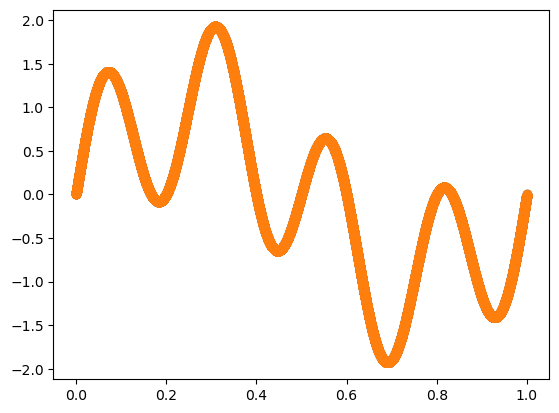

In [1]:
import numpy as np
import matplotlib.pyplot as plt
nax = np.newaxis

# input function
n_x = 1024
x = np.linspace(0, 1, n_x)
a = np.sin(2 * np.pi * x) + np.sin(8 * np.pi * x)

fig, ax = plt.subplots()
ax.scatter(x, a)

# Fourier transform
n_f = 128
f = np.arange(n_f)
norm = np.sqrt(n)
DFT = 1 / norm * np.exp(-2*np.pi*1j*f[:,nax]*x[nax,:]).T
Y = DFT @ y

# inverse Fourier transform
IDFT = 1 / norm * np.exp(2*np.pi*1j*x[:,nax]*f[nax,:]).T
yp = IDFT @ Y

# reconstructed signal
ax.scatter(x, yp)